# 1. Neural Networks with Numpy

In this notebook we will build our first neural network using only `numpy` as library.

We will work on the same dataset as last week and try to predict which digit is shown on the given pixel values.

In [2]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home="./data", cache=True)

We know already from last time how the data looks:

In [3]:
X.head(3)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The label is a number between 0-9 representing the digit shown on the pixels.

In [4]:
y.head(3)

0    5
1    0
2    4
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

As we can see from above, the label is given as a digit. However, to calculate the loss function of the neural network, we need the label as a one-hot-encoded version, in which the label is encoded as `1` and the rest as `0`.

For instance:
- `3` -> `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`
- `9` -> `[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]`

This is done in the following:

In [5]:
import pandas as pd
y_categorical = pd.get_dummies(y).astype('float32').values
y_categorical[0:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

Before we start, we scale the data and divide it into train and test data:

In [6]:
from sklearn.model_selection import train_test_split

X_scaled = (X/255).astype('float32').values
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.15, random_state=42)

## Task 1: Implement the Forward pass

We start with the following structure of a neural network with two hidden layers:
- Input layer of size 784 with sigmoid activation
- First hidden layer of size 128 with sigmoid activation
- Second hidden layer of size 64 with sigmoid activation
- Output layer of size 10 with softmax activation

A skeleton code for this network is given in the following class. Your first task is to complete the method `forward_pass` to calculate the forward pass on one data point. After this class you can find a test to check whether your implementation is correct.

In [7]:
import time
import numpy as np

class DeepNeuralNetwork():
    def __init__(self):
        
        # initialize weights randomly
        np.random.seed(0)
        self.w1 = np.random.randn(128, 784)
        self.w2 = np.random.randn(64, 128)
        self.w3 = np.random.randn(10, 64)

    def forward_pass(self, x_train):
        z1 = np.dot(self.w1, x_train)
        a1 = 1/(1 + np.exp(-z1)) # sigmoid activation
        z2 = np.dot(self.w2, a1)
        a2 = 1/(1 + np.exp(-z2)) # sigmoid activation
        z3 = np.dot(self.w3, a2)
        a3 = np.exp(z3)/sum(np.exp(z3)) # softmax activation
        
        # we need to remember all values for backpropagation
        self.fwdpass = [x_train, z1, a1, z2, a2, z3, a3]
        
        return a3
    
    
    def backprop(self, y, y_hat):
        # restore values from foward pass
        a0, z1, a1, z2, a2, z3, a3 = self.fwdpass
        
        # Calculate W3 update
        exps = np.exp(z3 - z3.max())
        softmax_derivative = exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        error = 2 * (y_hat - y) / y_hat.shape[0] * softmax_derivative
        gradient_w3 = np.outer(error, a2)

        # Calculate W2 update
        sigmoid_derivative = (np.exp(-z2))/((np.exp(-z2)+1)**2)
        error = np.dot(self.w3.T, error) * sigmoid_derivative
        gradient_w2 = np.outer(error, a1)

        # Calculate W1 update
        sigmoid_derivative = (np.exp(-z1))/((np.exp(-z1)+1)**2)
        error = np.dot(self.w2.T, error) * sigmoid_derivative
        gradient_w1 = np.outer(error, a0)

        return [gradient_w1, gradient_w2, gradient_w3]

In [8]:
# Test for task 1:
dnn = DeepNeuralNetwork()

# the network outputs a probability for every neuron in the last layer
y_hat = dnn.forward_pass(X_train[0])
print("The output of the last layer looks like this:\n", y_hat)

# to check if the network works correctly, check if the following condition is True
abs(y_hat[8] - 0.946) < 0.001

The output of the last layer looks like this:
 [5.13892189e-02 4.31072252e-06 2.25095624e-08 4.20524030e-08
 1.16018028e-09 3.04792788e-07 7.17666893e-05 1.95730962e-03
 9.46575277e-01 1.74626318e-06]


True

In [9]:
print(dnn.forward_pass(X_train[0]))

[5.13892189e-02 4.31072252e-06 2.25095624e-08 4.20524030e-08
 1.16018028e-09 3.04792788e-07 7.17666893e-05 1.95730962e-03
 9.46575277e-01 1.74626318e-06]


### Task 2: Implement  the training procedure

We can now start training the network by implementing the training procedure. We train the network for 10 epochs as shown in the code below.
In each epoch we go over every data point `x` in `X_train` and:
1. Calculate a forward pass on `x` as `y_hat`
2. Calculate the gradients for the weight in w1, w2 and w3 using the `backprop` function of the network
3. Update the weights w1, w2 and w3 of the network by moving into the negative direction of the gradient multiplied with the `learning_rate`
4. Bonus: Calculate the cross-entropy-loss after each epoch and plot it in relation to the epochs.



In [10]:
dnn = DeepNeuralNetwork()

no_epochs = 10
learning_rate = 0.01

start_time = time.time()
losses = []
for iteration in range(no_epochs):
    loss = 0
    for x,y in zip(X_train, y_train):
        y_hat = dnn.forward_pass(x)
        gradients = dnn.backprop(y, y_hat)
        
        loss += -np.log(np.dot(y, y_hat))
        
        # one step stochastic gradient descent
        dnn.w1 -= learning_rate * gradients[0]
        dnn.w2 -= learning_rate * gradients[1]
        dnn.w3 -= learning_rate * gradients[2]

    print(f'Epoch: {iteration+1}, Time: {time.time() - start_time:.1f}s, Loss: {loss:.0f}')
    losses.append(loss)

Epoch: 1, Time: 17.8s, Loss: 161410
Epoch: 2, Time: 33.9s, Loss: 102991
Epoch: 3, Time: 51.8s, Loss: 80930
Epoch: 4, Time: 70.4s, Loss: 66489
Epoch: 5, Time: 87.1s, Loss: 57511
Epoch: 6, Time: 102.9s, Loss: 51712
Epoch: 7, Time: 119.2s, Loss: 47585
Epoch: 8, Time: 135.9s, Loss: 44429
Epoch: 9, Time: 154.0s, Loss: 41907
Epoch: 10, Time: 171.6s, Loss: 39830


Text(0, 0.5, 'loss')

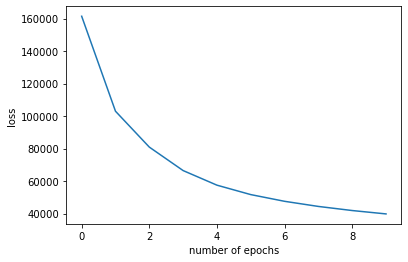

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(range(0, no_epochs), losses)
plt.xlabel('number of epochs')
plt.ylabel('loss')

### Task 3: Predict on the test data

After the network is trained, we can use it to predict on the test data.

__Task__: 
- Iterate over the test data and use the trained network the predict on every test data point.
- Identify the index of the neuron which returned the highest probability.
- Compare this value to the true label in the test data.
- Compute the accuracy.

In [12]:
predictions = []
for x, y in zip(X_test, y_test):
    output = dnn.forward_pass(x)
    pred = np.argmax(output)
    predictions.append(pred == np.argmax(y))
accuracy = np.mean(predictions)
print(accuracy)

0.7936190476190477


### Bonus Task:
- Remove the first hidden layer. Train the network and check the performance on the test data.

In [15]:
import time
import numpy as np

class DeepNeuralNetworkSmall():
    def __init__(self):
        
        # initialize weights randomly
        np.random.seed(0)
        self.w1 = np.random.randn(64, 784)
        self.w2 = np.random.randn(10, 64)

    def forward_pass(self, x_train):
        z1 = np.dot(self.w1, x_train)
        a1 = 1/(1 + np.exp(-z1)) # sigmoid activation
        z2 = np.dot(self.w2, a1)
        a2 = np.exp(z2)/sum(np.exp(z2)) # softmax activation
        
        # we need to remember all values for backpropagation
        self.fwdpass = [x_train, z1, a1, z2, a2]
        
        return a2
    
    
    def backprop(self, y, y_hat):
        # restore values from foward pass
        a0, z1, a1, z2, a2 = self.fwdpass
        
        # Calculate W2 update
        exps = np.exp(z2 - z2.max())
        softmax_derivative = exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        error = 2 * (y_hat - y) / y_hat.shape[0] * softmax_derivative
        gradient_w2 = np.outer(error, a1)

        # Calculate W1 update
        sigmoid_derivative = (np.exp(-z1))/((np.exp(-z1)+1)**2)
        error = np.dot(self.w2.T, error) * sigmoid_derivative
        gradient_w1 = np.outer(error, a0)

        return [gradient_w1, gradient_w2]

In [17]:
dnn = DeepNeuralNetworkSmall()

no_epochs = 10
learning_rate = 0.01

start_time = time.time()
losses = []
for iteration in range(no_epochs):
    loss = 0
    for x,y in zip(X_train, y_train):
        y_hat = dnn.forward_pass(x)
        gradients = dnn.backprop(y, y_hat)
        
        loss += -np.log(np.dot(y, y_hat))
        
        # one step stochastic gradient descent
        dnn.w1 -= learning_rate * gradients[0]
        dnn.w2 -= learning_rate * gradients[1]

    print(f'Epoch: {iteration+1}, Time: {time.time() - start_time:.1f}s, Loss: {loss:.0f}')
    losses.append(loss)

Epoch: 1, Time: 9.8s, Loss: 237385
Epoch: 2, Time: 19.6s, Loss: 130831
Epoch: 3, Time: 29.6s, Loss: 99504
Epoch: 4, Time: 40.1s, Loss: 79784
Epoch: 5, Time: 50.1s, Loss: 66653
Epoch: 6, Time: 59.9s, Loss: 57996
Epoch: 7, Time: 69.9s, Loss: 52095
Epoch: 8, Time: 79.7s, Loss: 47924
Epoch: 9, Time: 89.7s, Loss: 44824
Epoch: 10, Time: 99.9s, Loss: 42405


In [18]:
predictions = []
for x, y in zip(X_test, y_test):
    output = dnn.forward_pass(x)
    pred = np.argmax(output)
    predictions.append(pred == np.argmax(y))
accuracy = np.mean(predictions)
print(accuracy)

0.7852380952380953
